# Python Website Reader

Mit diesem Notebook werden die folgenden Websites besucht und die News in Markdown angezeigt und können auch als Markdown-file abgespeichert werden.

Der Pfad und der Filename kann in der aufrufenden Function savefile('D:\\temp', 'srf.md', stream) angepasst werden. Aktuell ist die Function auskommentiert.

<mark>**Bitte zuerst die erste Zelle ausführen, damit die Farben für den Output und der Newsr-Reader geladen sind.**</mark>

In [88]:
# coding=utf-8
# Run this cell to load the colors and the newsreader-function
import requests, html2text
import os, sys, getopt, socket
import locale, re
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pymongo, dns

class colors: 
    '''Colors class:reset all colors with colors.reset'''
    reset         = '\033[0m'
    bold          = '\033[01m'
    disable       = '\033[02m'
    underline     = '\033[04m'
    reverse       = '\033[07m'
    strikethrough = '\033[09m'
    invisible     = '\033[08m'

    class fg: 
        ''' Define the foreground-colors, use as colors.fg.colorname
        '''
        black      = '\033[30m'
        red        = '\033[31m'
        green      = '\033[32m'
        orange     = '\033[33m'
        blue       = '\033[34m'
        purple     = '\033[35m'
        cyan       = '\033[36m'
        lightgrey  = '\033[37m'
        darkgrey   = '\033[90m'
        lightred   = '\033[91m'
        lightgreen = '\033[92m'
        yellow     = '\033[93m'
        lightblue  = '\033[94m'
        pink       = '\033[95m'
        lightcyan  = '\033[96m'

    class bg: 
        ''' Define the background-colors, use as colors.bg.colorname
        '''
        black     = '\033[40m'
        red       = '\033[41m'
        green     = '\033[42m'
        orange    = '\033[43m'
        blue      = '\033[44m'
        purple    = '\033[45m'
        cyan      = '\033[46m'
        lightgrey = '\033[47m'

def newsreader(url, search_from, search_to, links=True, images=True, emphasis=True):
    '''Reads the given url and return the content a markdown'''
    response = requests.get(url)
    if(response.status_code == 200):
        html_content = response.content.decode('utf-8')
        # Format to markdown
        md = html2text.HTML2Text()
        md.ignore_links    = not links
        md.ignore_images   = not images
        md.ignore_emphasis = not emphasis
        md.body_width      = 100
        md_data            = md.handle(html_content)
        #read from start-pattern to end-pattern
        start  = md_data.find(search_from)
        end    = md_data.find(search_to)
        stream = [(md_data[start:end])]

    return stream

# Covid19-CH API
def get_api_context(url):
    '''return JSON-file'''
    from bson.json_util import loads
    response = requests.get(url +"/context")
    if(response.status_code == 200):
        html_content = response.content.decode('utf-8')
        json_data = loads(html_content)
        if "dataVersion" in json_data:
            dataVersion = json_data["dataVersion"]
        else:
            dataVersion = None
            print("dataVersion not found")

        return dataVersion

    else:
        print(response.status_code)


def get_api_data(url, type, last_update):
    '''return JSON'''
    from bson.json_util import loads
    data_json_url = url + "/sources/COVID19" + type + "_geoRegion.json"
    response = requests.get(data_json_url)
    if(response.status_code == 200):
        html_content = response.content.decode("utf-8")
        json_data = loads(html_content)
        for row in json_data:
            if row["geoRegion"] == "CH":
                if row["datum"] == last_update:
                    return "Total:\t" + str(row["sumTotal"]) + "\nToday:\t" + str(row["entries_diff_last"])


def add_document(connectionstring, mongodatabase, collection, document):
    '''Connect to MongoDB and add a document'''
    import pymongo
    mongo_client = pymongo.MongoClient(connectionstring)
    mongo_db     = mongo_client[mongodatabase]
    mongo_col    = mongo_db[collection]
    mongo_col.insert_one(document)
    for doc in mongo_col.find():
        print(doc)

    mongo_client.close()

def get_collection(connectionstring, database, collection):
    '''Connect to MongoDB and return data'''
    mongo_client = pymongo.MongoClient(connectionstring)
    mongo_db     = mongo_client[database]
    mongo_col    = mongo_db[collection]
    mongo_client.close()
    return mongo_col.find()

def search_for_document(connectionstring, database, collection, filter):
    """Search for a document

    Args:
        connectionstring (String): Connection-string of the MongoDB
        database (String): Database name to export the data
        collection (String): Collection name to export the data
        filter (String): Filter to search for

    Example:
        credentials = input('user:password')
        connectionstring = "mongodb+srv://"+credentials+"@cluster0.epl3x.mongodb.net/?retryWrites=true&w=majority"
        search_for_document(connectionstring, 'JupyterNB', 'PoweredOffVMs', { "PSComputerName": "TIN87500803.child.domain.com" })
    """
    mongo_client = pymongo.MongoClient(connectionstring)
    mongo_db     = mongo_client[database]
    mongo_col    = mongo_db[collection]
    for doc in mongo_col.find(filter):
        return doc

## SRF News
Code mit <mark> Run Cell </mark> ausführen um die SRF News anzuzeigen.

In [ ]:
# Run this cell to get the news from www.srf.ch
url = 'https://www.srf.ch/news/neuste-beitraege'
now = datetime.now()
print(colors.bold + colors.fg.blue +'{1}{0}{4} {2}{0}{3}{0}'.format('\n', '>' * 100, f'NEWS FROM: {url}', '<' * 100, now.strftime("%Y-%m-%d %H:%M:%S")) + colors.reset)

stream = newsreader(url, '###  Neueste Beiträge', '## Footer', False, False)
for i in stream:
    if(i is not None):
        line = i
        line = line.replace('Mit Video\n\n','')
        line = line.replace('Mit Audio\n\n','')
        line = line.replace('###  Neueste Beiträge\n\n','')
        line = line.replace('  * ','### ')
        print('{0}{1}{2}'.format(colors.fg.green, line, colors.reset))

## Covid-⁠19 Schweiz
Code mit <mark> Run Cell </mark> ausführen um die aktuellen Covidzahlen vom BAG anzuzeigen und die Daten in die MongoDB abzuspeichern. Die Tagesübersicht mit History wird als Tabelle mit den letzten 7 Datensätzen ausgegeben.

### Übersicht gesamter Zeitraum

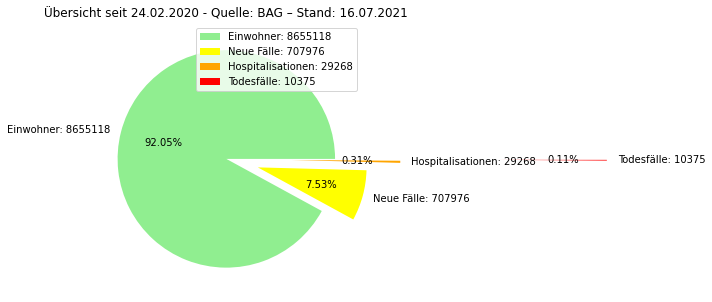

In [101]:
# Create pie chart with data from www.covid19.admin.ch

news = 'https://www.covid19.admin.ch/de/overview?ovTime=total'

# Get data from the website
list_html = newsreader(news, '### Laborbestätigte Fälle', '### Laborbestätigte Hospitalisationen')
for line in list_html:
    if(line is not None):
        Datum = (re.findall('Quelle: BAG – Stand:\s\d{2}\.\d{2}\.\d{4}',line)[0])
        Fälle = ((re.findall('Total seit 24.02.2020+\|\s\d{1,}\s\d{1,}',line)[0]).split('| ')[1]).replace(' ','')
        break

list_html = newsreader(news, '### Laborbestätigte Hospitalisationen', '### Laborbestätigte Todesfälle')
for line in list_html:
    if(line is not None):
        Hospitalisationen = ((re.findall('Total seit 24.02.2020+\|\s\d{1,}\s\d{1,}',line)[0]).split('| ')[1]).replace(' ','')
        break

list_html = newsreader(news, '### Laborbestätigte Todesfälle','### Tests und Anteil positive Tests')
for line in list_html:
    if(line is not None):
        Todesfälle = ((re.findall('Total seit 24.02.2020+\|\s\d{1,}\s\d{1,}',line)[0]).split('| ')[1]).replace(' ','')
        break

# Out chart
## Define pie chart
first_value = '24.02.2020'

### Calculate sum of values
sum_of_swiss_people  = 8655118
sum_of_new_cases     = int(Fälle)
sum_of_new_hosp      = int(Hospitalisationen)
sum_of_new_dead      = int(Todesfälle)

### Calculate percent of values
pct_swiss_people     = "{:.2%}".format(1)
pct_new_cases        = "{:.2%}".format(sum_of_new_cases / sum_of_swiss_people)
pct_new_hosp         = "{:.2%}".format(sum_of_new_hosp  / sum_of_swiss_people)
pct_new_dead         = "{:.2%}".format(sum_of_new_dead  / sum_of_swiss_people)

### Create the dictionary
sum_pie_dict = {
    'Summe'  :[sum_of_swiss_people,sum_of_new_cases,sum_of_new_hosp,sum_of_new_dead],
    'Percent':[pct_swiss_people,pct_new_cases,pct_new_hosp,pct_new_dead]
}
#display(sum_pie_df)

### Create the data frame set
sum_pie_df = pd.DataFrame(data=sum_pie_dict)
pie_index  = [
    f'Einwohner: {sum_of_swiss_people}',
    f'Neue Fälle: {sum_of_new_cases}',
    f'Hospitalisationen: {sum_of_new_hosp}',
    f'Todesfälle: {sum_of_new_dead}'
]

### Print out the pie cahrt
sum_plot_colors = ['lightgreen', 'yellow', 'orange', 'red']
sum_pie_explode = (0,0.3,0.6,2.5)
pie = sum_pie_df.plot.pie(
    title   = f"Übersicht seit {first_value} - {Datum}", 
    labels  = pie_index,
    legend  = True,
    ylabel  = "", y = 'Summe',  
    autopct = '%1.2f%%', 
    #table   = True, 
    colors  = sum_plot_colors, 
    explode = sum_pie_explode, 
    figsize = (15,5), 
)

### Save chart as png-file
current_dir = os.getcwd()
parent_dir  = os.path.dirname(current_dir) 
fig = pie.get_figure()
fig.savefig(f'{parent_dir}/images/covid-overview.png', facecolor='w', bbox_inches='tight')
print()

### Tagesübersicht mit History

Neue Fälle
{'Datum': '16.07.2021', 'Neue Fälle': '617', 'Hospitalisationen': '5', 'Todesfälle': '1'}


Tagesübersicht aus MongoDB


,UUID,Datum,Neue Fälle,Hospitalisationen,H/NF,Todesfälle,T/NF,T/H
0,605a677858b6a1bc070542b9,2021-03-23,1844,74,4.01%,11,0.60%,14.86%
1,605b32132443b6c0d2b993e0,2021-03-24,2022,83,4.10%,20,0.99%,24.10%
2,605cae67a53d17a176fce6e6,2021-03-25,2046,74,3.62%,69,3.37%,93.24%
3,605e08d3de8527974712ee10,2021-03-26,2053,50,2.44%,10,0.49%,20.00%
4,6062bf8c88501c0a5a1e06bd,2021-03-29,3798,67,1.76%,14,0.37%,20.90%
...,...,...,...,...,...,...,...,...
104,60f06a0d391439155ab88f79,2021-07-12,818,8,0.98%,2,0.24%,25.00%
105,60f06a0d391439155ab88f7a,2021-07-13,480,5,1.04%,5,1.04%,100.00%
106,60f06a0d391439155ab88f7b,2021-07-14,526,9,1.71%,0,0.00%,0.00%
107,60f06a0d391439155ab88f7c,2021-07-15,581,7,1.20%,2,0.34%,28.57%


Tagesdurchschnitt aus MongoDB


,Seit Datum,Avg/Neue Fälle,Avg/Hospitalisationen,Avg/Todesfälle,Sum/Neue Fälle,Sum/Hospitalisationen,Sum/Todesfälle
0,2021-03-23,1783,66,12,194377,7290,1365


Laborbestätige Fälle als Charts


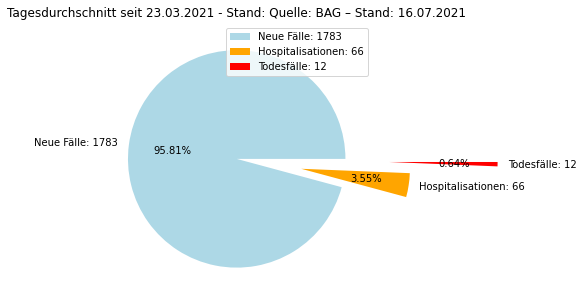

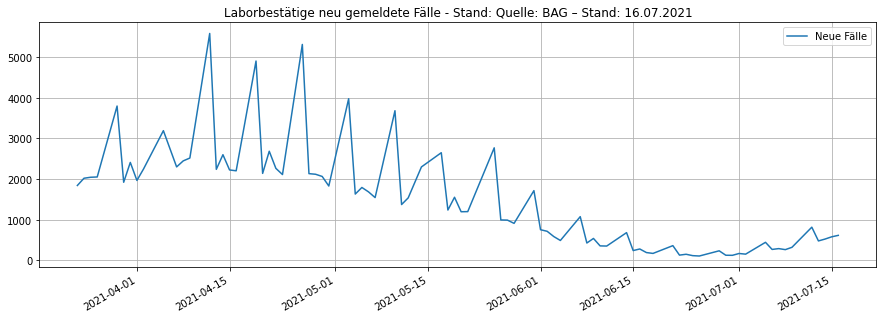

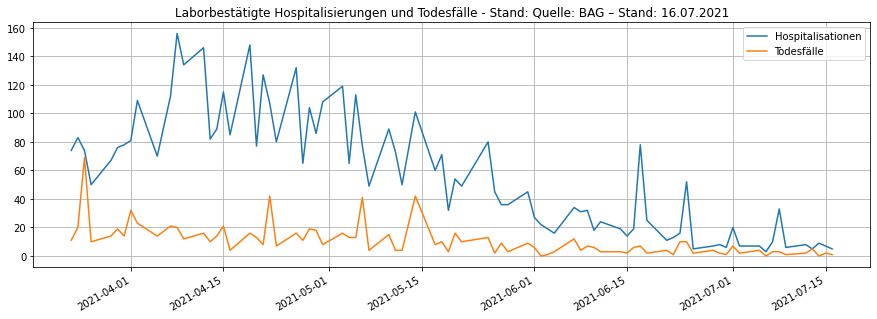

In [119]:
# Get data from BAG-API and save it to the MongoDB
import datetime as dt, time
api_url      = "https://www.covid19.admin.ch/api/data"
data_version = get_api_context(api_url)
last_update  = data_version[0:4] + "-" + data_version[4:6] + "-" + data_version[6:8]
dt_format    = "%Y-%m-%d"
dt_today     = dt.datetime.today()
str_today    = dt_today.strftime(dt_format)
dt_weekday   = dt.datetime.strptime(str_today, dt_format).strftime('%A')

if dt_weekday == 'Saturday' or dt_weekday == 'Sunday':
    print('Its weekend, there are no new data availyble at ' + dt_weekday)
    pass
else:
    #print('Its ' + dt_weekday)
    data_version_url = api_url + "/" + data_version
    if data_version_url:
        cases = get_api_data(data_version_url, "Cases", last_update)
        hosp  = get_api_data(data_version_url, "Hosp", last_update)
        death = get_api_data(data_version_url, "Death", last_update)

        dt_last_update   = dt.datetime.strptime(last_update, dt_format)
        dt_format        = "%d.%m.%Y"
        str_last_update  = dt_last_update.strftime(dt_format)
        # Create a dictionary for MongoDB
        document = {
            "Datum"            : str_last_update,
            "Neue Fälle"       : cases.split("\t")[2],
            "Hospitalisationen": hosp.split("\t")[2],
            "Todesfälle"       : death.split("\t")[2],
        }
        print('{0}Neue Fälle{1}'.format(colors.bold + colors.fg.blue, colors.reset))
        print(str(document))

        '''
        credentials = input('user:password')
        '''
        connectionstring = "mongodb+srv://"+credentials+"@cluster0.epl3x.mongodb.net/?retryWrites=true&w=majority"

        filter = { "Datum": str_last_update }
        match = search_for_document(connectionstring, 'JupyterNB', 'Covid19', filter)
        if match:
            pass
        else:
            print('{0}No matches found, add document to MongoDB{1}'.format(colors.fg.green, colors.reset))
            add_document(connectionstring, 'JupyterNB', 'Covid19', document)

result_of_history = []
for doc in get_collection(connectionstring, 'JupyterNB', 'Covid19'):
    thisdict = {     
            'UUID'              : doc['_id'],                           
            'Datum'             : datetime.strptime(doc['Datum'], '%d.%m.%Y'),
            'Neue Fälle'        : int(doc['Neue Fälle']),
            'Hospitalisationen' : int(doc['Hospitalisationen']),
            'H/NF'              : "{:.2%}".format(int(doc['Hospitalisationen']) / int(doc['Neue Fälle'])),
            'Todesfälle'        : int(doc['Todesfälle']),
            'T/NF'              : "{:.2%}".format(int(doc['Todesfälle']) / int(doc['Neue Fälle'])),
            'T/H'               : "{:.2%}".format(int(doc['Todesfälle']) / int(doc['Hospitalisationen']))
    }
    result_of_history.append(thisdict)

## Create a data frame set and print out
print('{0}Tagesübersicht aus MongoDB{1}'.format(colors.bold + colors.fg.blue, colors.reset))
df = pd.DataFrame(result_of_history)
display(df)

# Create charts with data from MongoDB
current_dir = os.getcwd()
parent_dir  = os.path.dirname(current_dir) 

count_of_datum = df.Datum.count()
first_value    = str(re.findall('\d{4}\-\d{2}\-\d{2}', str(df.Datum.values[0]))[0])
us_date_fomat  = datetime.strptime(first_value, "%Y-%m-%d")
ch_date_fomat  = datetime.strftime(us_date_fomat, "%d.%m.%Y")
#last_value     = str(re.findall('\d{4}\-\d{2}\-\d{2}', str(df.Datum.values[count_of_datum -1]))[0])
plot_colors    = ['lightblue', 'orange','red']
#pie_index      = ['Neue Fälle','Hospitalisationen','Todesfälle']

## Build sum of data
sum_of_swiss_people = 8655118
sum_of_new_cases    = int(df['Neue Fälle'].sum())
sum_of_new_hosp     = int(df['Hospitalisationen'].sum())
sum_of_new_dead     = int(df['Todesfälle'].sum())

## Build average of data
avg_of_new_cases = int(sum_of_new_cases / count_of_datum)
avg_of_new_hosp  = int(sum_of_new_hosp / count_of_datum)
avg_of_new_dead  = int(sum_of_new_dead / count_of_datum)

## Create the dictionary with avg and sum
pie_index   = [
    f'Neue Fälle: {avg_of_new_cases}',
    f'Hospitalisationen: {avg_of_new_hosp}',
    f'Todesfälle: {avg_of_new_dead}'
]

pie_dict = {
    'Average':[avg_of_new_cases,avg_of_new_hosp,avg_of_new_dead],
    'Summe'  :[sum_of_new_cases,sum_of_new_hosp,sum_of_new_dead],
}

## Create the thable with avg and sum
table_data = [{
    'Seit Datum'            : first_value,
    'Avg/Neue Fälle'        : avg_of_new_cases,
    'Avg/Hospitalisationen' : avg_of_new_hosp, 
    'Avg/Todesfälle'        : avg_of_new_dead,
    'Sum/Neue Fälle'        : sum_of_new_cases,
    'Sum/Hospitalisationen' : sum_of_new_hosp,
    'Sum/Todesfälle'        : sum_of_new_dead,
}]

### Print data frame set as table
print('{0}Tagesdurchschnitt aus MongoDB{1}'.format(colors.bold + colors.fg.blue, colors.reset))
sum_of_table = pd.DataFrame(data = table_data)
display(sum_of_table)

### Print data frame set as pie chart
print('{0}Laborbestätige Fälle als Charts{1}'.format(colors.bold + colors.fg.blue, colors.reset))
avg_pie_df = pd.DataFrame(data = pie_dict)
avg_pie_explode = (0,0.6,1.4)
pie = avg_pie_df.plot.pie(
    #subplots = True, 
    ylabel  = "", y = 'Average', 
    title   = f"Tagesdurchschnitt seit {ch_date_fomat} - Stand: {Datum}", 
    labels  = pie_index, 
    #table   = True, 
    autopct = '%1.2f%%', 
    colors  = plot_colors, 
    explode = avg_pie_explode, 
    figsize = (15,5)
)
### Save chart as png-file
fig = pie.get_figure()
fig.savefig(f'{parent_dir}/images/covid-dayli-overview.png', facecolor='w', bbox_inches='tight')

### Print data frame set as line chart
df = pd.DataFrame(result_of_history)
chart = df.plot.line(
    x       = "Datum", 
    xlabel  = "", 
    ylabel  = "", 
    y       = ["Neue Fälle"], 
    title   = f"Laborbestätige neu gemeldete Fälle - Stand: {Datum}", 
    grid    = True, 
    legend  = True, 
    figsize = (15,5)
)

### Save chart as png-file
fig = chart.get_figure()
fig.savefig(f'{parent_dir}/images/covid-dayli-newcases.png', facecolor='w', bbox_inches='tight')

chart = df.plot.line(
    x       = "Datum", 
    xlabel  = "", 
    ylabel  = "", 
    y        = ["Hospitalisationen","Todesfälle"], 
    title    = f"Laborbestätigte Hospitalisierungen und Todesfälle - Stand: {Datum}", 
    grid    = True, 
    legend  = True, 
    figsize = (15,5)
)
### Save chart as png-file
fig = chart.get_figure()
fig.savefig(f'{parent_dir}/images/covid-dayli-host-dead.png', facecolor='w', bbox_inches='tight')
print("")

### MongoDB

Code mit <mark>Run Cell</mark> ausführen um die Daten in die MongoDB abzuspeichern.

Add manual documents

In [ ]:
# Write manual data to the MongoDB
"""
credentials = input('user:password')
connectionstring = "mongodb+srv://"+credentials+"@cluster0.epl3x.mongodb.net/?retryWrites=true&w=majority"
document = {
    "Datum"            : "11.04.2021",
    "Neue Fälle"       : "802",
    "Hospitalisationen": "7",
    "Todesfälle"       : "2"
}
add_document(connectionstring, 'JupyterNB', 'Covid19', document)
"""

## Südostschweiz
Code  mit <mark> Run Cell </mark> ausführen um die Südostschweiz News anzuzeigen.

In [ ]:
# Run this cell to get the news from www.suedostschweiz.ch
url = 'https://www.suedostschweiz.ch'
now = datetime.now()
print(colors.bold + colors.fg.blue +'{1}{0}{4} {2}{0}{3}{0}'.format('\n', '>' * 100, f'NEWS FROM: {url}', '<' * 100, now.strftime("%Y-%m-%d %H:%M:%S")) + colors.reset)
stream = newsreader(url, '# Startseite', '## 2\. GR Template Menu', False, False)
for i in stream:
    if(i is not None):
        line = i
        line = line.replace('ABO\n\n','')                
        line = line.replace('# Startseite\n\n','')
        line = line.replace(' __Audio __\n\n','')
        line = line.replace('Sponsored Content\n\n','')
        line = line.replace('  ','')
        line = line.replace('video\n\n','')
        line = line.replace('bilder\n\n','')
        line = line.replace('Mehr\n\n','')
        line = line.replace('Bildergalerie\n\n','')
        print('{0}{1}{2}'.format(colors.fg.green, line, colors.reset))